<a href="https://colab.research.google.com/github/mansurimn/MLselflearning/blob/main/MNIST_Autoencode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training data shape: (60000, 784)
Test data shape: (10000, 784)
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.3168 - val_loss: 0.1403
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.1324 - val_loss: 0.1123
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.1108 - val_loss: 0.1032
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.1029 - val_loss: 0.0968
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0971 - val_loss: 0.0927
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0931 - val_loss: 0.0896
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0902 - val_loss: 0.0875
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0882 - val_loss: 0.0858
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0866 - val_loss: 0.0847
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0850 - val_loss: 0.0837
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


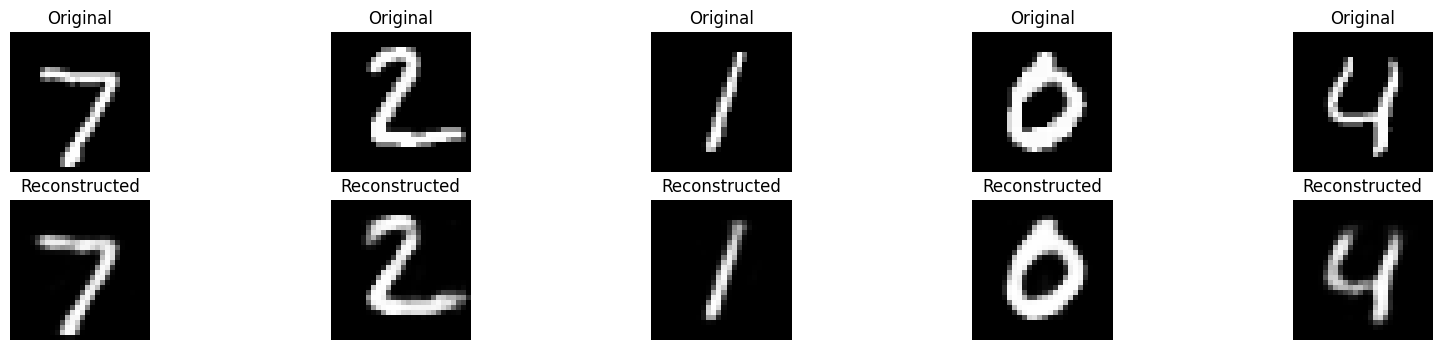

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# 1. Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and flatten images (28x28 -> 784)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

# 2. Define Autoencoder
input_dim = x_train.shape[1]  # 784

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)   # compressed representation

# Decoder
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)

# Compile
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

# 3. Train Autoencoder
history = autoencoder.fit(
    x_train, x_train,  # input = output
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

# 4. Test the model
reconstructed = autoencoder.predict(x_test)

# 5. Visualization: show original and reconstructed images
n = 5  # number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()


100%|██████████| 9.91M/9.91M [00:00<00:00, 55.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.30MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.66MB/s]


Epoch [1/5], Loss: 0.0458
Epoch [2/5], Loss: 0.0333
Epoch [3/5], Loss: 0.0302
Epoch [4/5], Loss: 0.0291
Epoch [5/5], Loss: 0.0281


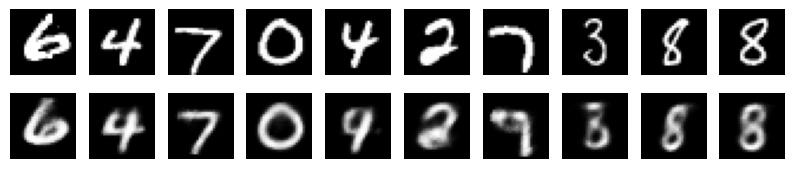

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. Dataset & DataLoader
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# 2. Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),   # bottleneck (latent space)
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 3. Initialize Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training Loop
epochs = 5
for epoch in range(epochs):
    for img, _ in train_loader:
        img = img.view(-1, 28*28).to(device)
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 5. Visualization
test_img, _ = next(iter(train_loader))
test_img = test_img.view(-1, 28*28).to(device)
with torch.no_grad():
    reconstructed = model(test_img)

# Show original vs reconstructed
fig, axes = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    axes[0][i].imshow(test_img[i].cpu().view(28, 28), cmap="gray")
    axes[0][i].axis("off")
    axes[1][i].imshow(reconstructed[i].cpu().view(28, 28), cmap="gray")
    axes[1][i].axis("off")
plt.show()


# MNIST Autoencoder (PyTorch)

## 📌 Overview
This project implements a simple **Autoencoder** using PyTorch on the **MNIST dataset**.  
An autoencoder is an unsupervised neural network that learns efficient representations of data by compressing (encoding) and reconstructing (decoding).

---

## ⚡ Workflow
1. **Input**: MNIST digit images (28x28).
2. **Encoder**: Compresses images into a latent vector (size = 12).
3. **Decoder**: Reconstructs images from latent space.
4. **Loss Function**: Mean Squared Error (MSE) between original and reconstructed images.
5. **Optimization**: Adam optimizer with learning rate = 0.001.

---

## 🛠 Model Architecture
- **Encoder**:  
  - Linear(784 → 128) → ReLU  
  - Linear(128 → 64) → ReLU  
  - Linear(64 → 12) → ReLU  

- **Decoder**:  
  - Linear(12 → 64) → ReLU  
  - Linear(64 → 128) → ReLU  
  - Linear(128 → 784) → Sigmoid  

---

## 🚀 Training
- Dataset: MNIST (60,000 train images, 10,000 test images)
- Batch Size: 128  
- Epochs: 5  
- Optimizer: Adam  
- Loss: MSELoss  

---

## 📊 Results
### Example Reconstructions
- Top row: Original images  
- Bottom row: Reconstructed images  

(A visualization script using Matplotlib is included in the code.)

---

## 🔮 Future Work
- Add convolutional layers for better image reconstruction.  
- Experiment with different latent space sizes.  
- Apply to colored images (CIFAR-10, CelebA).  

---
